In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import openTSNE
from umap import UMAP
from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")

In [64]:
train = pd.read_csv("/root/autodl-tmp/XJTU-ELEC427304-homework/kaggle_graduate_prediect/train.csv", index_col="id")
test = pd.read_csv("/root/autodl-tmp/XJTU-ELEC427304-homework/kaggle_graduate_prediect/test.csv", index_col="id")

In [65]:
target = "Target"

In [66]:
features = test.columns.to_list()

In [67]:
categorical_features = train.select_dtypes(include=int).columns.to_list()
continuous_features = train.select_dtypes(include=float).columns.to_list()

In [68]:
categorical_features

['Marital status',
 'Application mode',
 'Application order',
 'Course',
 'Daytime/evening attendance',
 'Previous qualification',
 'Nacionality',
 "Mother's qualification",
 "Father's qualification",
 "Mother's occupation",
 "Father's occupation",
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'Age at enrollment',
 'International',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (without evaluations)']

In [69]:
continuous_features

['Previous qualification (grade)',
 'Admission grade',
 'Curricular units 1st sem (grade)',
 'Curricular units 2nd sem (grade)',
 'Unemployment rate',
 'Inflation rate',
 'GDP']

In [70]:
discrete_features = [col for col in categorical_features if col.startswith("Curricular")] + ["Age at enrollment"]
discrete_features

['Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (without evaluations)',
 'Age at enrollment']

In [71]:
categorical_features = list(np.setdiff1d(categorical_features, discrete_features))
categorical_features

['Application mode',
 'Application order',
 'Course',
 'Daytime/evening attendance',
 'Debtor',
 'Displaced',
 'Educational special needs',
 "Father's occupation",
 "Father's qualification",
 'Gender',
 'International',
 'Marital status',
 "Mother's occupation",
 "Mother's qualification",
 'Nacionality',
 'Previous qualification',
 'Scholarship holder',
 'Tuition fees up to date']

In [72]:
train.shape

(76518, 37)

In [73]:
test.shape

(51012, 36)

In [74]:
def customDescription(df: pd.DataFrame, numeric_only: bool = True):
    if numeric_only:
        df = df.select_dtypes(include=np.number)
    desc = pd.DataFrame(index=df.columns.to_list())
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] / len(df) * 100
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc = pd.concat([desc, df.describe().T.drop('count', axis=1)], axis=1)

    if numeric_only:
        desc["skew"] = df.skew()
        desc["kurtosis"] = df.kurtosis()
    desc = desc.round(2)
    return desc

In [75]:
customDescription(train)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max,skew,kurtosis
Marital status,int64,76518,6,0.01,0,0.0,1.11,0.44,1.00,1.00,1.00,1.00,6.00,5.38,34.87
Application mode,int64,76518,22,0.03,0,0.0,16.05,16.68,1.00,1.00,17.00,39.00,53.00,0.60,-1.24
Application order,int64,76518,8,0.01,0,0.0,1.64,1.23,0.00,1.00,1.00,2.00,9.00,2.04,3.39
Course,int64,76518,19,0.02,0,0.0,9001.29,1803.44,33.00,9119.00,9254.00,9670.00,9991.00,-4.48,19.08
Daytime/evening attendance,int64,76518,2,0.00,0,0.0,0.92,0.28,0.00,1.00,1.00,1.00,1.00,-2.98,6.90
Previous qualification,int64,76518,21,0.03,0,0.0,3.66,8.62,1.00,1.00,1.00,1.00,43.00,3.44,10.79
Previous qualification (grade),float64,76518,110,0.14,0,0.0,132.38,11.00,95.00,125.00,133.10,140.00,190.00,0.22,1.16
Nacionality,int64,76518,18,0.02,0,0.0,1.23,3.39,1.00,1.00,1.00,1.00,109.00,20.07,493.32
Mother's qualification,int64,76518,35,0.05,0,0.0,19.84,15.40,1.00,1.00,19.00,37.00,44.00,-0.05,-1.65
Father's qualification,int64,76518,39,0.05,0,0.0,23.43,14.92,1.00,4.00,19.00,37.00,44.00,-0.44,-1.41


In [76]:
customDescription(test)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max,skew,kurtosis
Marital status,int64,51012,6,0.01,0,0.0,1.11,0.44,1.00,1.00,1.00,1.00,6.00,5.44,35.27
Application mode,int64,51012,20,0.04,0,0.0,16.07,16.65,1.00,1.00,17.00,39.00,53.00,0.60,-1.24
Application order,int64,51012,8,0.02,0,0.0,1.65,1.24,0.00,1.00,1.00,2.00,9.00,2.05,3.47
Course,int64,51012,21,0.04,0,0.0,9026.30,1751.33,33.00,9119.00,9254.00,9670.00,9991.00,-4.63,20.56
Daytime/evening attendance,int64,51012,2,0.00,0,0.0,0.92,0.27,0.00,1.00,1.00,1.00,1.00,-3.05,7.33
Previous qualification,int64,51012,20,0.04,0,0.0,3.64,8.58,1.00,1.00,1.00,1.00,43.00,3.45,10.93
Previous qualification (grade),float64,51012,108,0.21,0,0.0,132.33,10.89,95.00,125.00,133.10,139.00,190.00,0.24,1.20
Nacionality,int64,51012,18,0.04,0,0.0,1.20,3.26,1.00,1.00,1.00,1.00,109.00,21.86,573.35
Mother's qualification,int64,51012,32,0.06,0,0.0,19.91,15.38,1.00,1.00,19.00,37.00,44.00,-0.05,-1.64
Father's qualification,int64,51012,36,0.07,0,0.0,23.54,14.88,1.00,5.00,19.00,37.00,43.00,-0.45,-1.40


In [77]:
train.duplicated().sum()

0

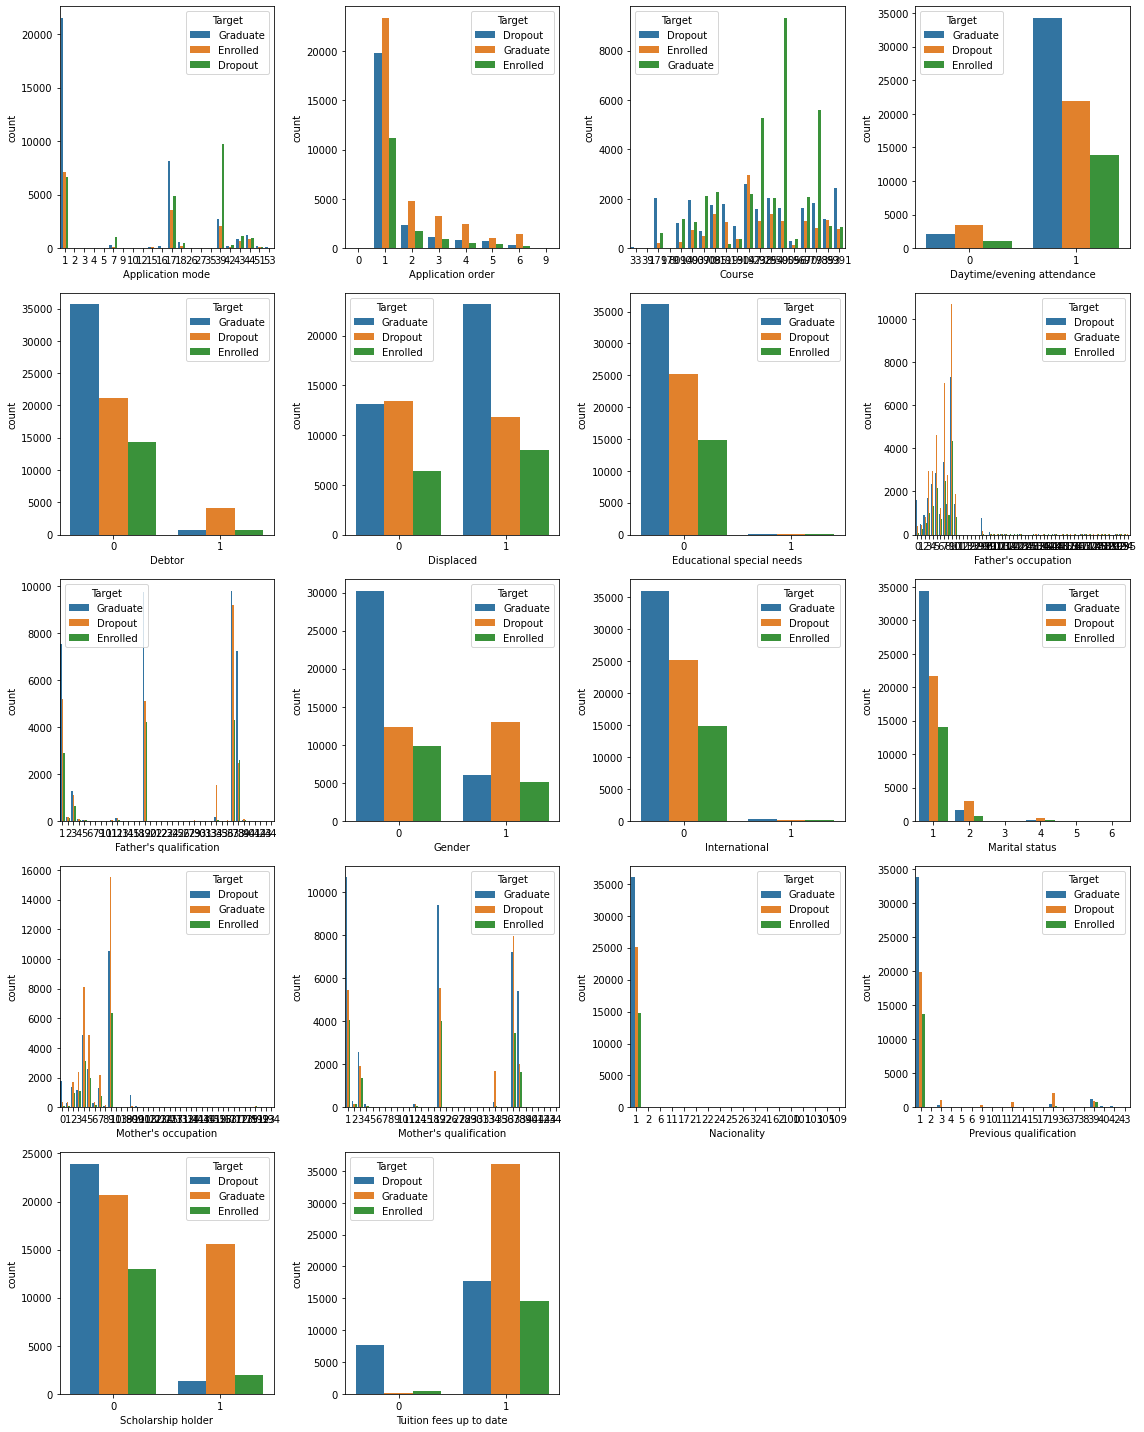

In [78]:
plt.figure(figsize=(16, 20))
for i, col in enumerate(categorical_features):
    plt.subplot(5, 4, i+1)
    sns.countplot(data=train, x=col, hue=target)
plt.tight_layout()
plt.show()

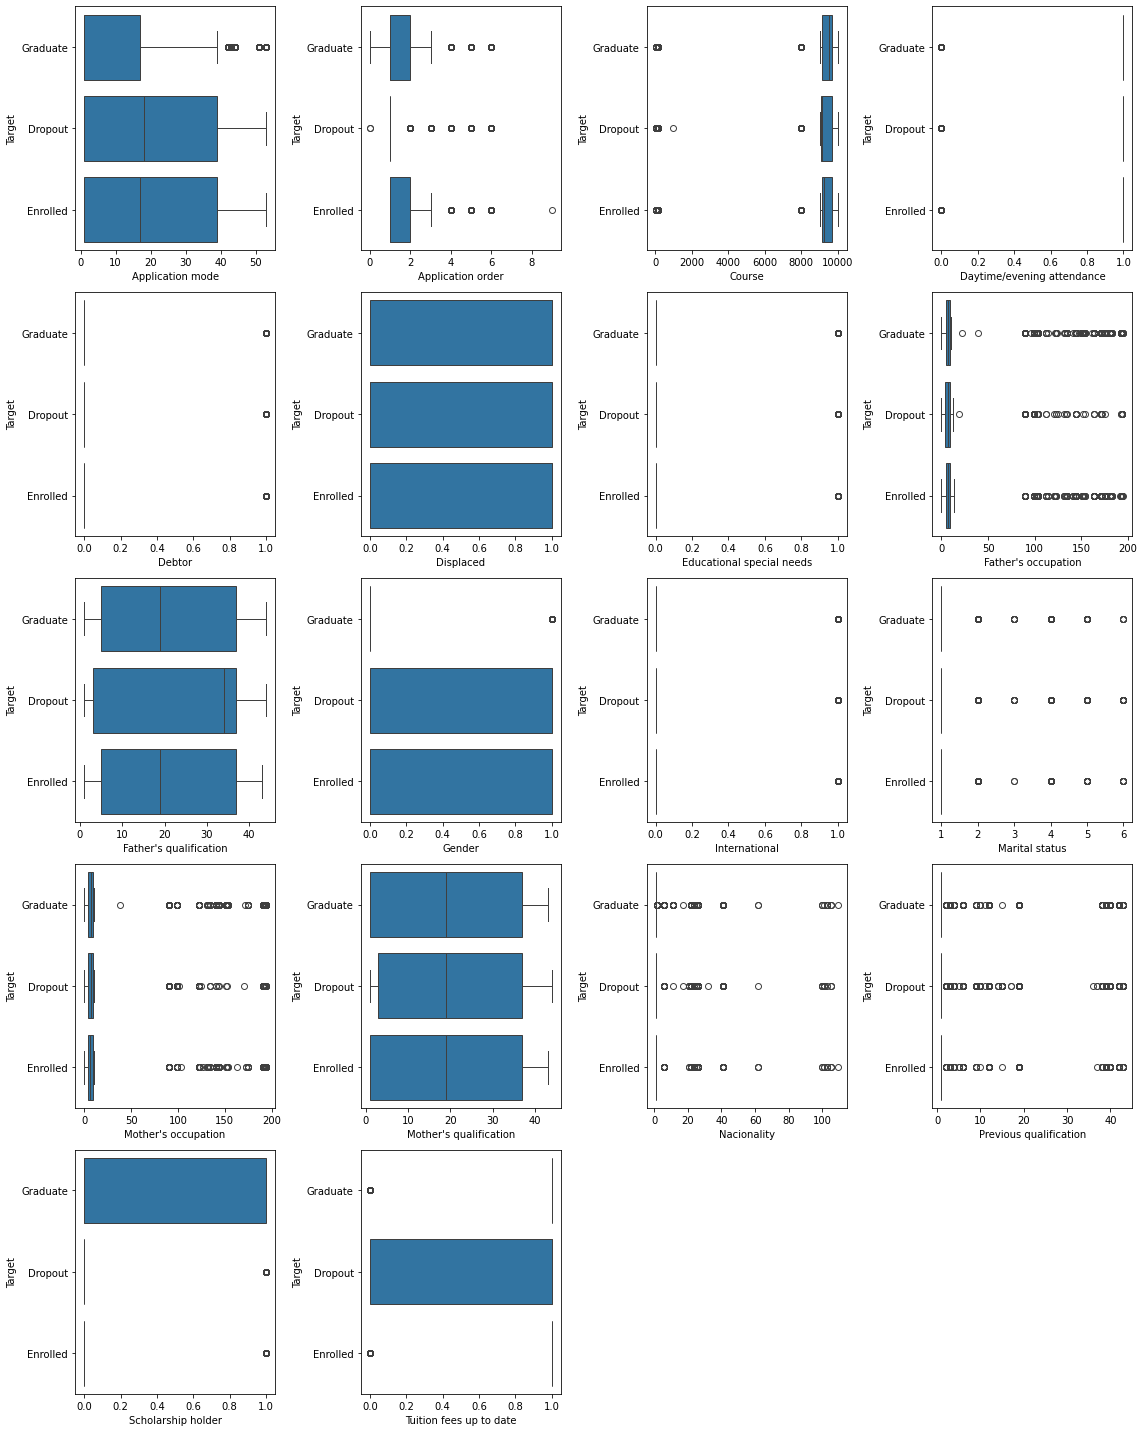

In [79]:
plt.figure(figsize=(16, 20))
for i, col in enumerate(categorical_features):
    plt.subplot(5, 4, i+1)
    sns.boxplot(data=train, x=col, y=target)
plt.tight_layout()
plt.show()

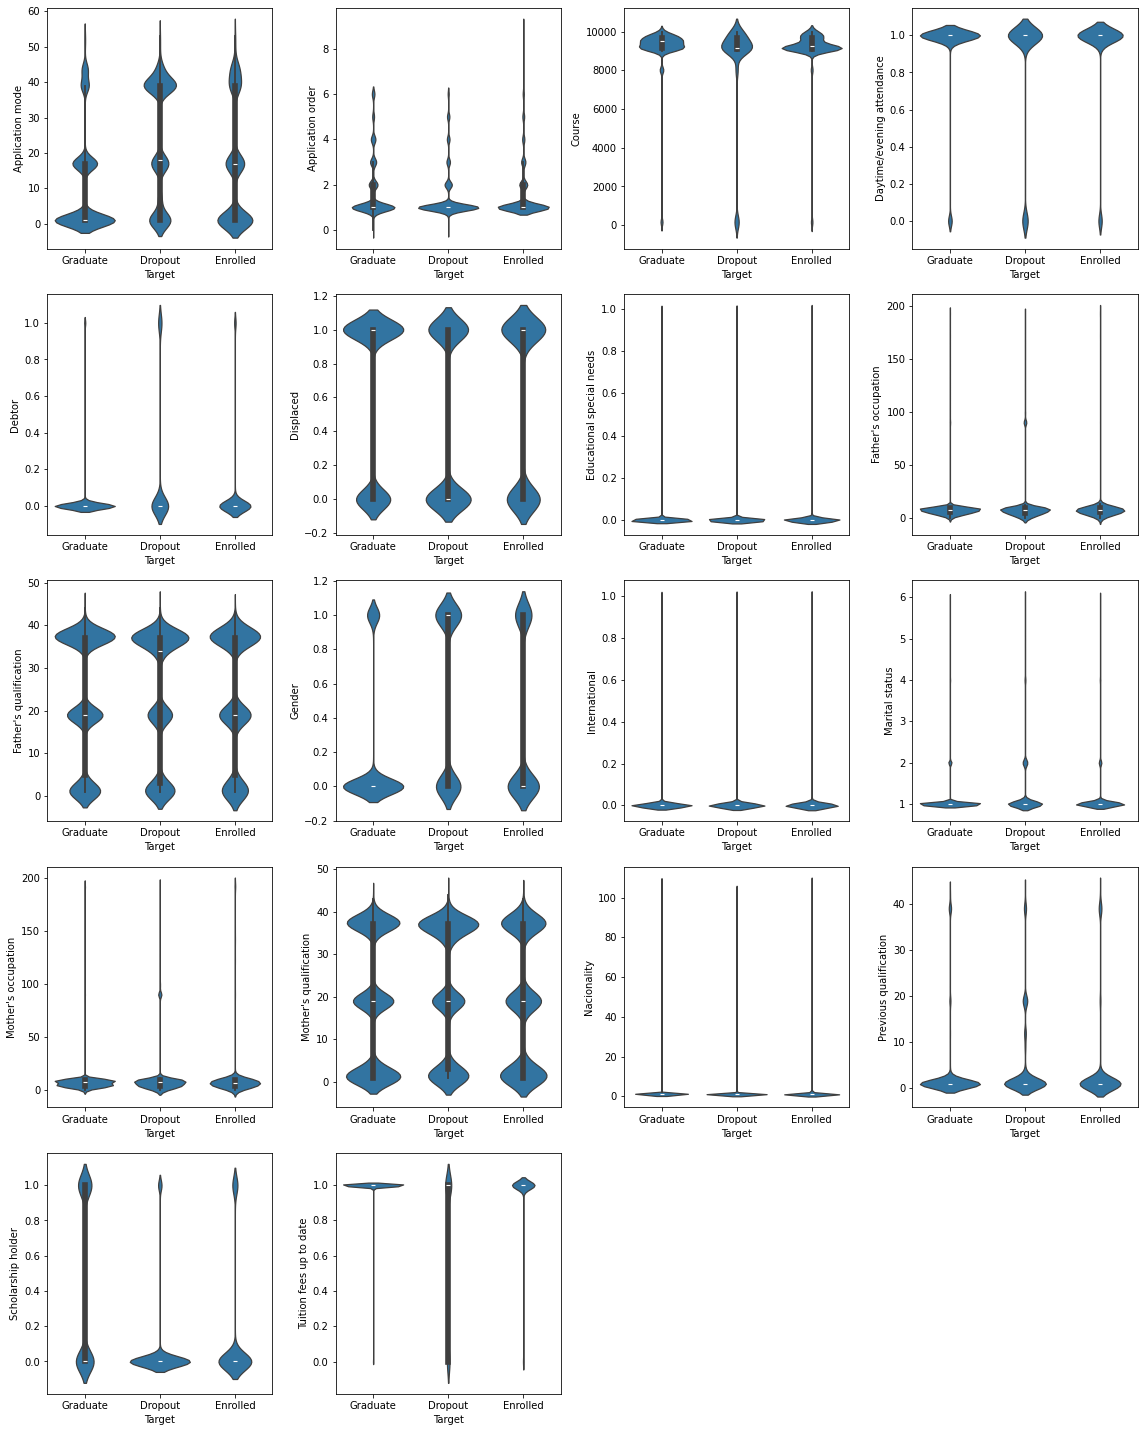

In [80]:
plt.figure(figsize=(16, 20))
for i, col in enumerate(categorical_features):
    plt.subplot(5, 4, i+1)
    sns.violinplot(data=train, x=target, y=col)
plt.tight_layout()
plt.show()

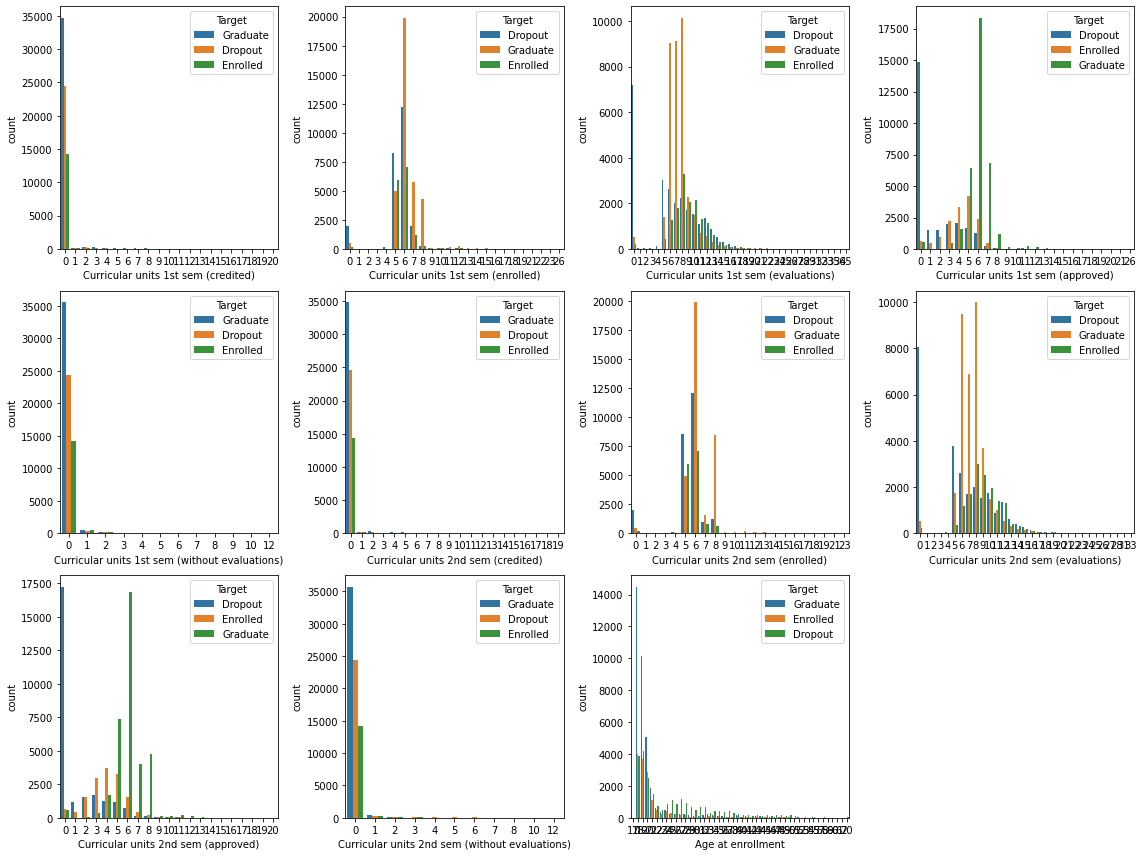

In [81]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(discrete_features):
    plt.subplot(3, 4, i+1)
    sns.countplot(data=train, x=col, hue=target)
plt.tight_layout()
plt.show()

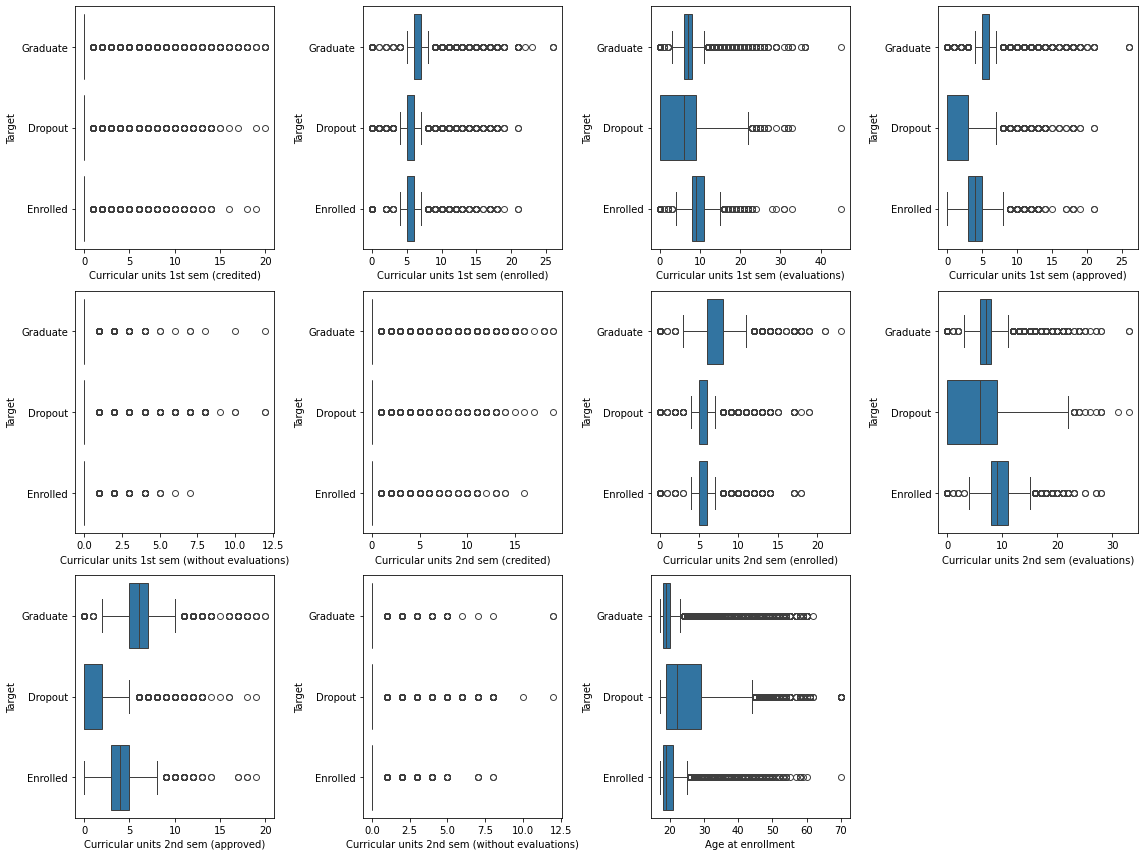

In [82]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(discrete_features):
    plt.subplot(3, 4, i+1)
    sns.boxplot(data=train, x=col, y=target)
plt.tight_layout()
plt.show()

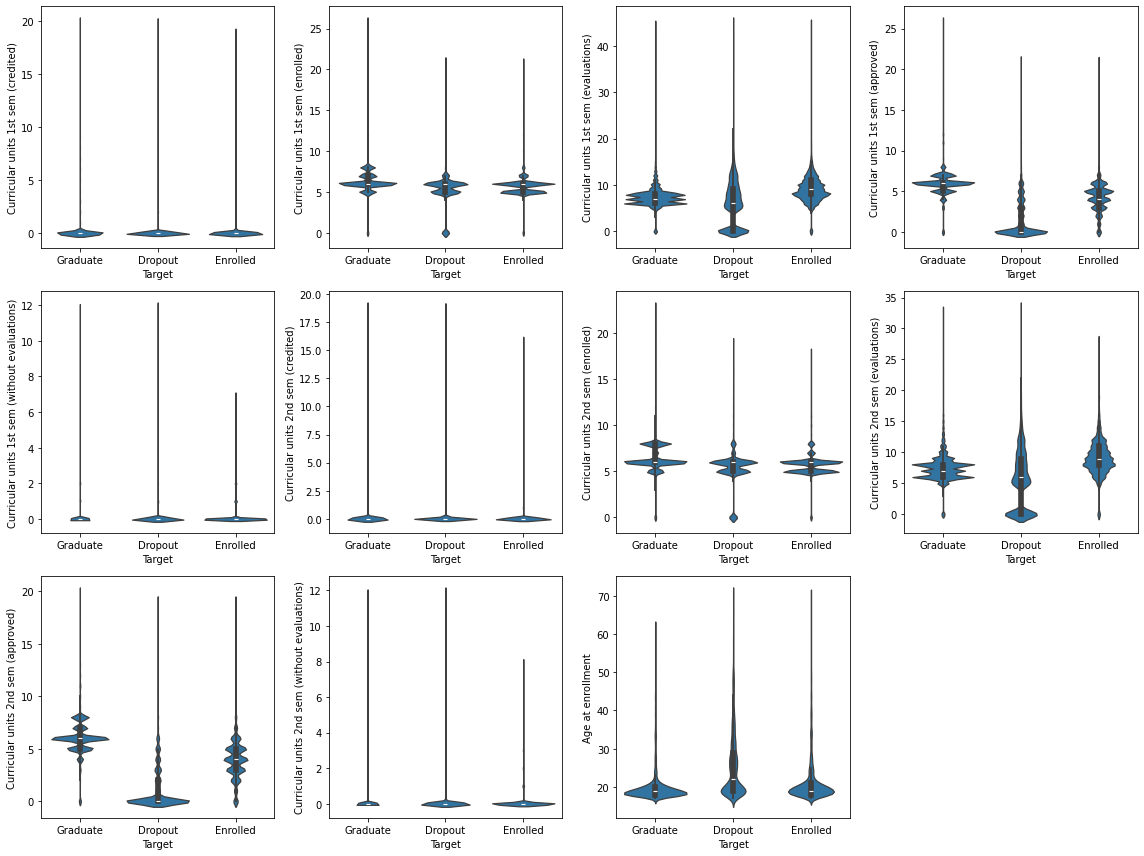

In [83]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(discrete_features):
    plt.subplot(3, 4, i+1)
    sns.violinplot(data=train, x=target, y=col)
plt.tight_layout()
plt.show()

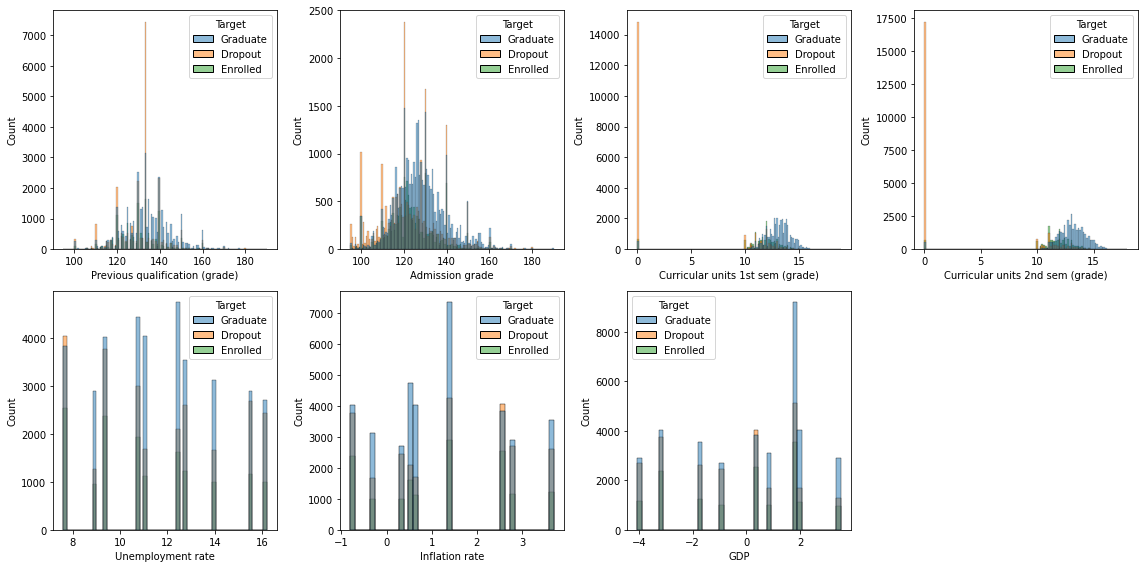

In [84]:
plt.figure(figsize=(16, 8))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 4, i+1)
    sns.histplot(data=train, x=col, hue=target)
plt.tight_layout()
plt.show()

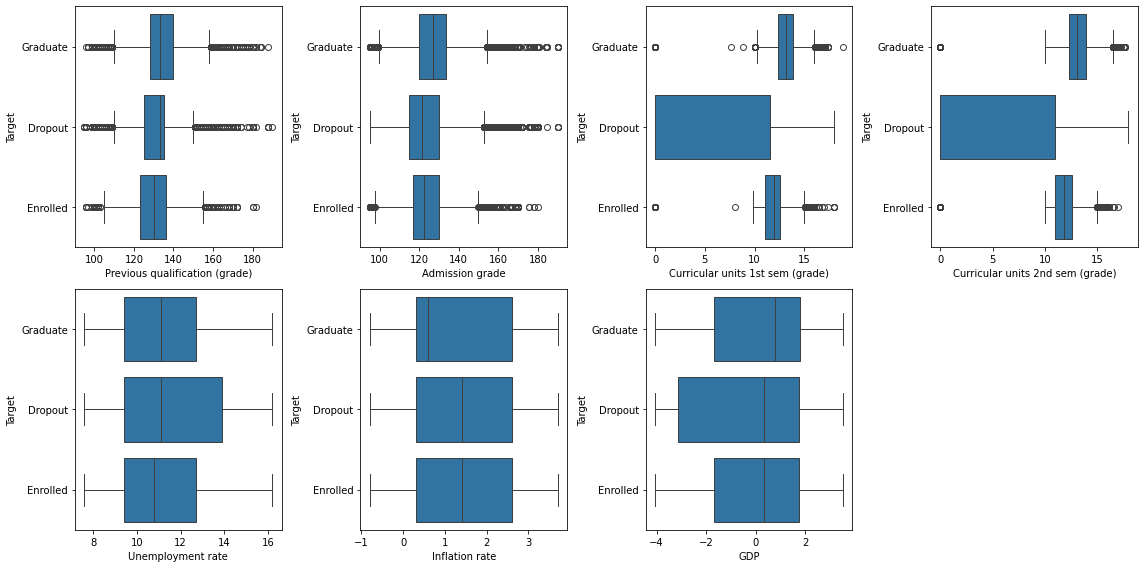

In [85]:
plt.figure(figsize=(16, 8))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 4, i+1)
    sns.boxplot(data=train, x=col, y=target)
plt.tight_layout()
plt.show()

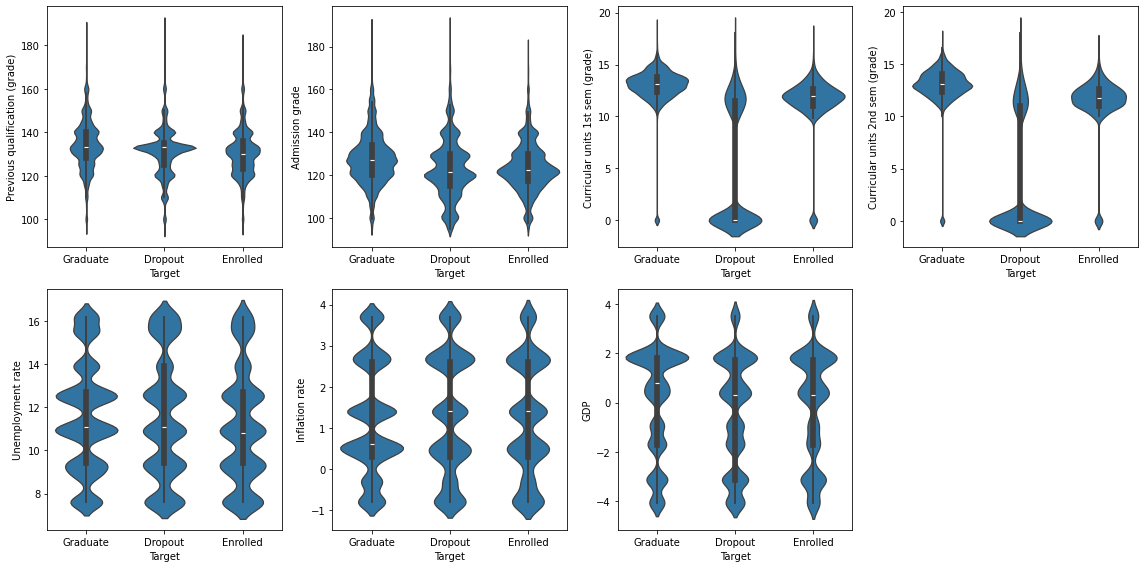

In [86]:
plt.figure(figsize=(16, 8))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 4, i+1)
    sns.violinplot(data=train, x=target, y=col)
plt.tight_layout()
plt.show()

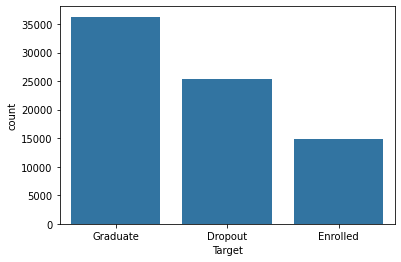

In [87]:
sns.countplot(data=train, x=target)
plt.show()

In [88]:
lab_enc = LabelEncoder()
train[target] = lab_enc.fit_transform(train[target])

In [89]:
sp_cols = [
    "Application mode",
    "Course",
    "Previous qualification",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]


def nunique(x):
    return len(np.unique(x))


unique_count = {}
unique_count["columns"] = sp_cols
unique_count["in_training"] = [nunique(train[col]) for col in sp_cols]
unique_count["training + test"] = [nunique(np.concatenate([train[col], test[col]])) for col in sp_cols]

pd.DataFrame(unique_count)

,columns,in_training,training + test
0,Application mode,22,24
1,Course,19,23
2,Previous qualification,21,22
3,Nacionality,18,19
4,Mother's qualification,35,37
5,Father's qualification,39,41
6,Mother's occupation,40,45
7,Father's occupation,56,58


In [90]:
lab_encoder = LabelEncoder()
for col in sp_cols:
    lab_encoder.fit(np.unique(np.concatenate([train[col], test[col]])))
    train[col] = lab_encoder.transform(train[col])
    test[col] = lab_encoder.transform(test[col])

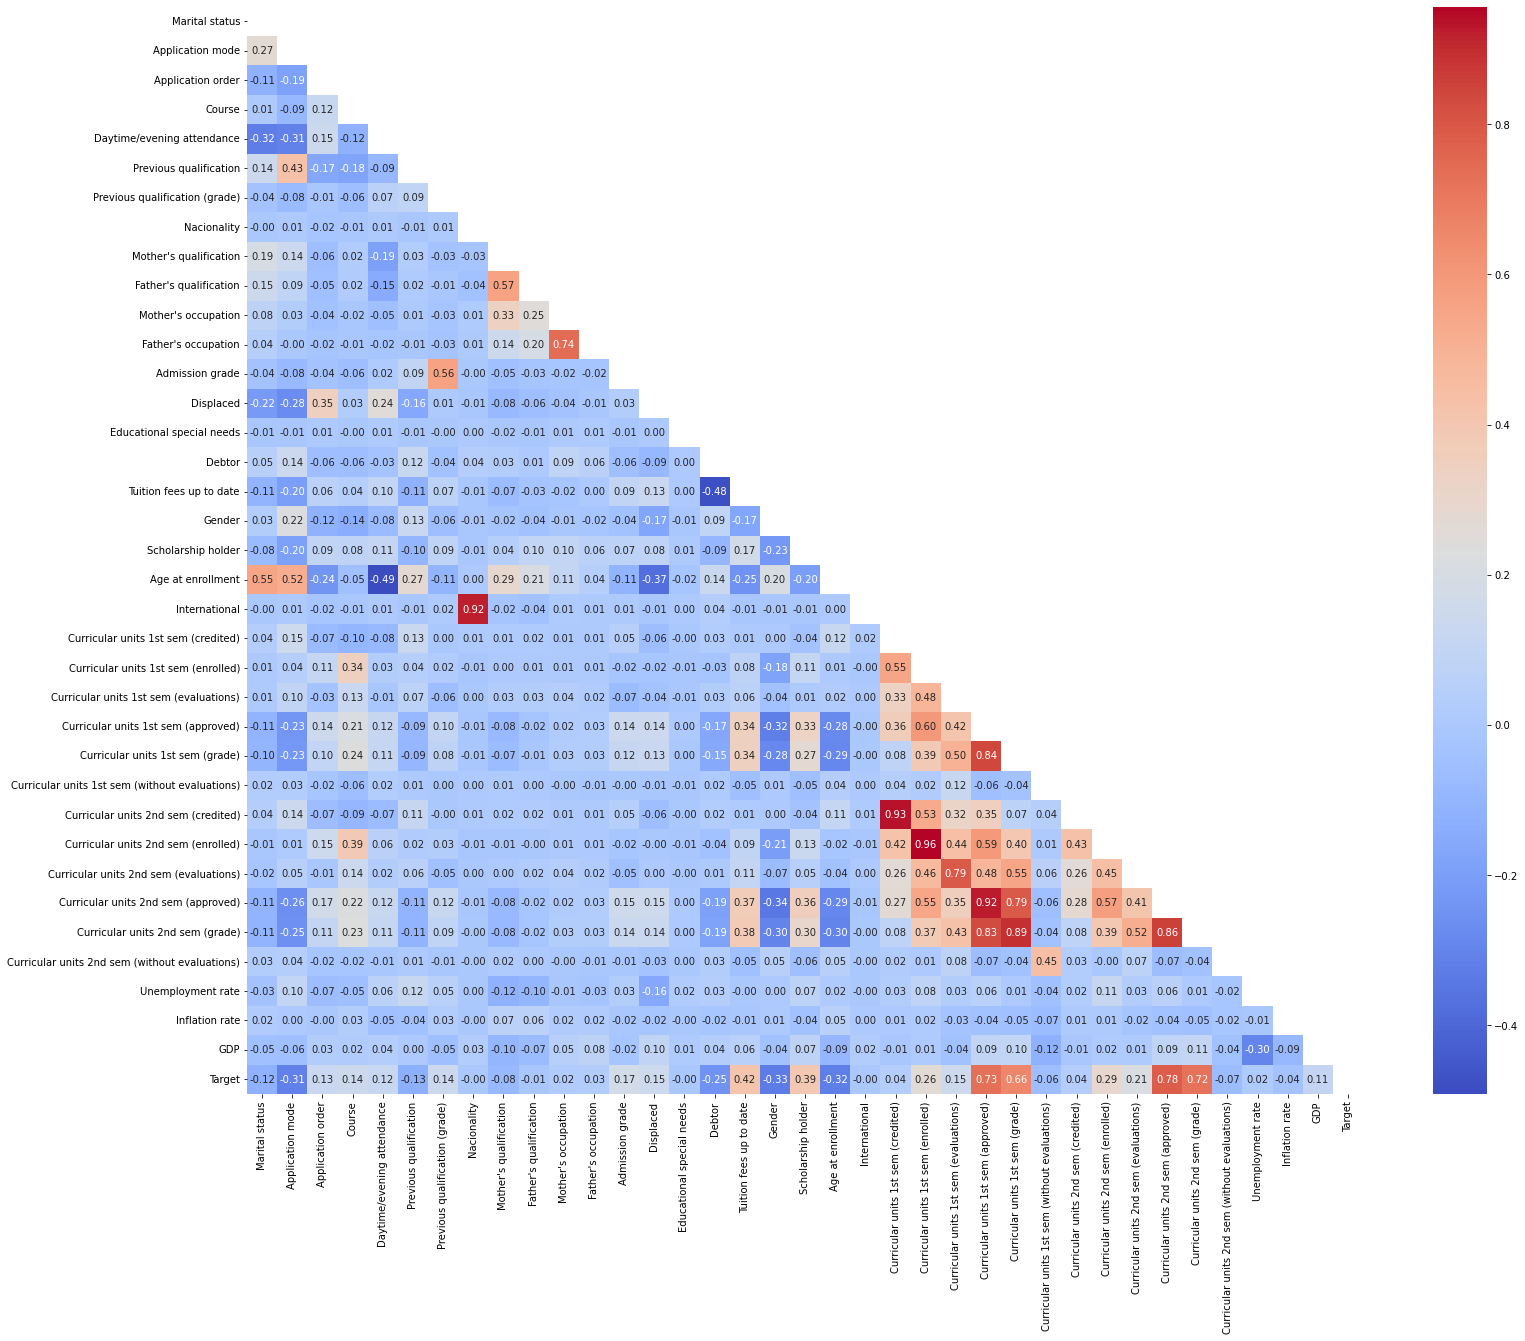

In [91]:
cor_mat = train.corr(method="pearson")

mask = np.triu(np.ones_like(cor_mat))

plt.figure(figsize=(25, 20))
sns.heatmap(cor_mat, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.show()

In [92]:
X = train.drop(target, axis=1)
y = train[target]

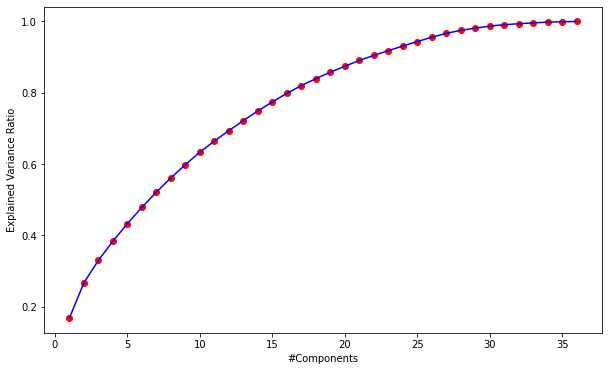

In [93]:
pca = PCA()

pca_pipe = make_pipeline(StandardScaler(), pca)

pca_pipe.fit(X)
explained_variance_ratio = np.cumsum(pca_pipe[-1].explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X.columns)+1), explained_variance_ratio, "b-")
plt.scatter(range(1, len(X.columns)+1), explained_variance_ratio, c="red")
plt.xlabel("#Components")
plt.ylabel("Explained Variance Ratio")
plt.show()

In [94]:
def plot(x, **kwargs):
    plt.scatter(x[:, 0], x[:, 1], c=y, s=3, **kwargs)

In [95]:
%%time

embedding_standard = openTSNE.TSNE(
    perplexity=30,
    initialization="random",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
).fit(np.array(X))

CPU times: user 5min, sys: 10.1 s, total: 5min 10s
Wall time: 2min 14s


In [96]:
%%time
embedding_pca = openTSNE.TSNE(
    perplexity=30,
    initialization="pca",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
).fit(np.array(X))

CPU times: user 5min 3s, sys: 13.8 s, total: 5min 16s
Wall time: 2min 15s


In [97]:
%%time
embedding_cosine = openTSNE.TSNE(
    perplexity=30,
    initialization="random",
    metric="cosine",
    n_jobs=8,
    random_state=3,
).fit(np.array(X))

CPU times: user 4min 56s, sys: 8.15 s, total: 5min 4s
Wall time: 2min 6s


In [98]:
%%time
embedding_pca_cosine = openTSNE.TSNE(
    perplexity=30,
    initialization="pca",
    metric="cosine",
    n_jobs=8,
    random_state=3,
).fit(np.array(X))

CPU times: user 4min 58s, sys: 12.7 s, total: 5min 10s
Wall time: 2min 10s


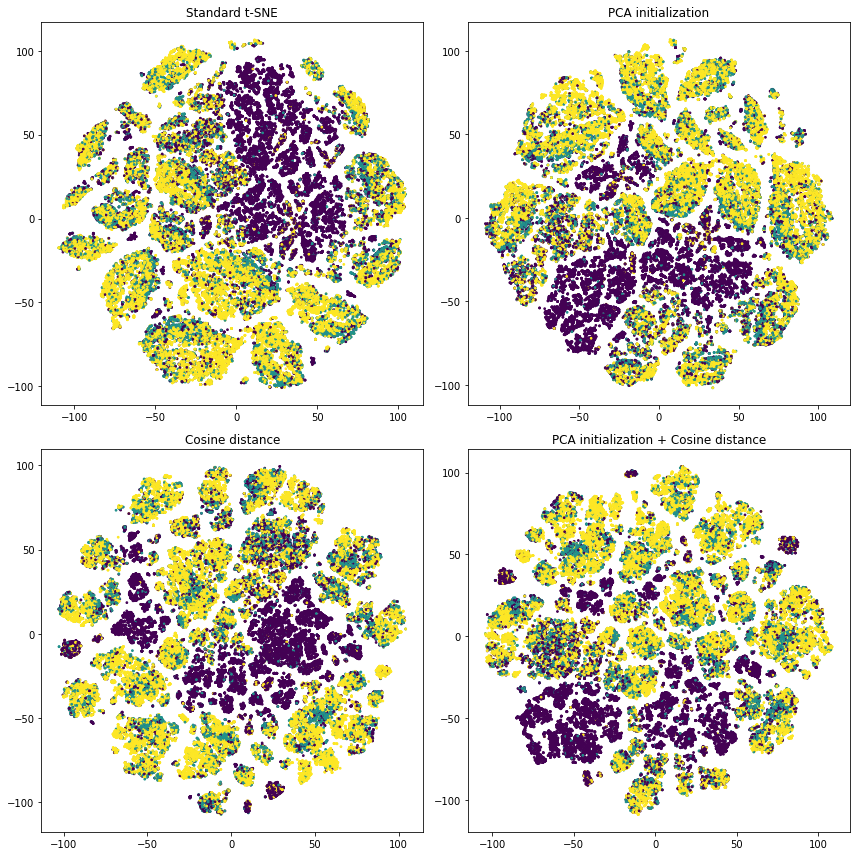

In [99]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plot(embedding_standard)
plt.title("Standard t-SNE")

plt.subplot(2, 2, 2)
plot(embedding_pca)
plt.title("PCA initialization")

plt.subplot(2, 2, 3)
plot(embedding_cosine)
plt.title("Cosine distance")

plt.subplot(2, 2, 4)
plot(embedding_pca_cosine)
plt.title("PCA initialization + Cosine distance")

plt.tight_layout()
plt.show()

In [100]:
train_sample = train.sample(5000)

reducer = UMAP()

res = reducer.fit_transform(train_sample.drop(target, axis=1))

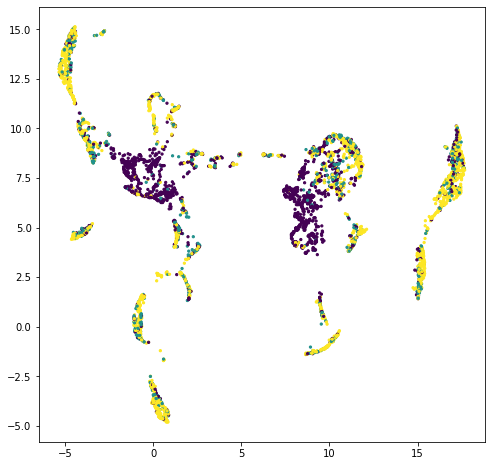

In [101]:
plt.figure(figsize=(8, 8))
plt.scatter(res[:, 0], res[:, 1], c=train_sample[target], s=5)
plt.show()

In [102]:
discrete_features = X.dtypes == int


def mi_score_maker(X, y, discrete_features):
    scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    df = pd.DataFrame({
        'Features': X.columns,
        'Scores': scores
    })
    df = df.sort_values(['Scores'], ascending=False).reset_index(drop=True)
    return df

In [103]:
mi_scores = mi_score_maker(X, y, discrete_features)

mi_scores

,Features,Scores
0,Curricular units 2nd sem (approved),0.478434
1,Curricular units 2nd sem (grade),0.416553
2,Curricular units 1st sem (approved),0.404898
3,Curricular units 1st sem (grade),0.365439
4,Curricular units 2nd sem (evaluations),0.195230
5,Curricular units 1st sem (evaluations),0.186579
6,Course,0.115707
7,Admission grade,0.104024
8,Tuition fees up to date,0.102676
9,Age at enrollment,0.096284


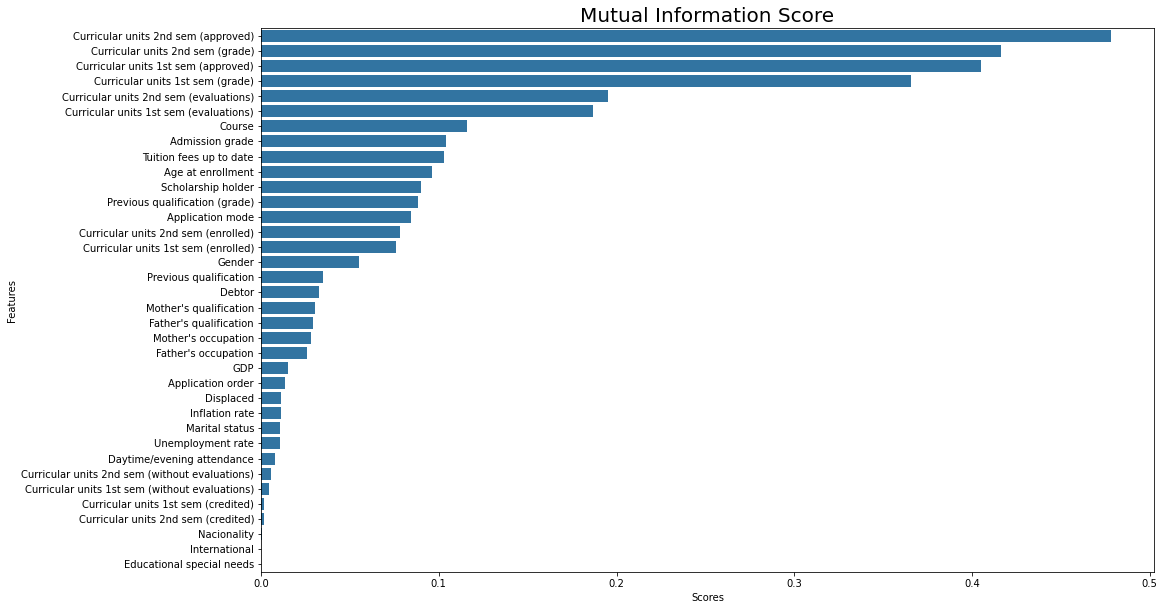

In [104]:
plt.figure(figsize=(16, 10))
sns.barplot(x="Scores", y="Features", data=mi_scores)
plt.title("Mutual Information Score", size=20)
plt.show()

In [105]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def model_scorer(model, X, y):
    scores = cross_val_score(model, X, y, cv=skfold, scoring="accuracy")
    return scores.mean()

In [106]:
%%time

cat_clf = CatBoostClassifier(allow_writing_files=False, verbose=False, task_type="GPU", random_state=42)
cat_pipe = make_pipeline(StandardScaler(), cat_clf)

model_scorer(cat_pipe, X, y)

CPU times: user 1min 30s, sys: 25.7 s, total: 1min 56s
Wall time: 37.9 s


0.8309547921843699

In [107]:
%%time

xgb_clf = XGBClassifier(device="cuda", random_state=42)
xgb_pipe = make_pipeline(StandardScaler(), xgb_clf)

model_scorer(xgb_pipe, X, y)

CPU times: user 13.7 s, sys: 151 ms, total: 13.9 s
Wall time: 6.87 s


0.8312945726339255

In [113]:
%%time

lgb_clf = LGBMClassifier(verbose=-1, device="cpu", random_state=42)
lgb_pipe = make_pipeline(StandardScaler(), lgb_clf)

model_scorer(lgb_pipe, X, y)

CPU times: user 1min 54s, sys: 411 ms, total: 1min 54s
Wall time: 11.1 s


0.8311900743374567

In [114]:
%%time

hgb_clf = HistGradientBoostingClassifier(random_state=42)
hgb_pipe = make_pipeline(StandardScaler(), hgb_clf)

model_scorer(hgb_pipe, X, y)

CPU times: user 3min 14s, sys: 533 ms, total: 3min 15s
Wall time: 18 s


0.8312815417327378

In [115]:
models = [
    ("cat", cat_clf),
    ("xgb", xgb_clf),
    ("lgb", lgb_clf),
    ("hgb", hgb_clf)
]

vtg_clf = VotingClassifier(estimators=models, voting="soft", n_jobs=-1)
vtg_pipe = make_pipeline(StandardScaler(), vtg_clf)

In [117]:
from lightgbm import LGBMClassifier


model_scorer(vtg_pipe, X, y)

0.832902050188288

In [119]:
x_train, x_test = train_test_split(train, test_size=0.1, shuffle=True, random_state=42, stratify=train.Target)
y_train = x_train.pop(target)
y_test = x_test.pop(target)

vtg_pipe.fit(x_train, y_train)
y_pred = vtg_pipe.predict(x_test)

print(classification_report(lab_enc.inverse_transform(y_test),
                            lab_enc.inverse_transform(y_pred)))


              precision    recall  f1-score   support

     Dropout       0.90      0.83      0.86      2530
    Enrolled       0.65      0.61      0.63      1494
    Graduate       0.85      0.92      0.88      3628

    accuracy                           0.83      7652
   macro avg       0.80      0.79      0.79      7652
weighted avg       0.83      0.83      0.83      7652



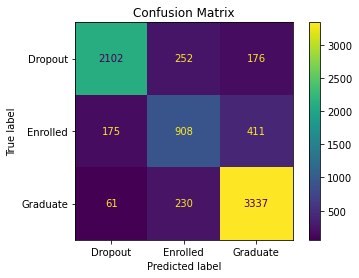

In [120]:
confusion_mat = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_mat, display_labels=lab_enc.classes_.tolist()).plot()
plt.title("Confusion Matrix")
plt.show()

In [121]:
vtg_pipe.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('votingclassifier',
                 VotingClassifier(estimators=[('cat',
                                               <catboost.core.CatBoostClassifier object at 0x7f7e1913d6d0>),
                                              ('xgb',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             device='cuda',
                                                             early_stopping_rounds=None,
                                                             enable_cate...
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                              ('lgb',
                                               LGBMClassifier(device='cpu',
                                                              random_state=42,
                                                              verbose=-1)),
                                              ('hgb',
                                               HistGradientBoostingClassifier(random_state=42))],
                                  n_jobs=-1, voting='soft'))])

In [122]:
test_pred = vtg_pipe.predict(test)

In [124]:
sub = pd.read_csv("/root/autodl-tmp/XJTU-ELEC427304-homework/kaggle_graduate_prediect/sample_submission.csv")
sub[target] = lab_enc.inverse_transform(test_pred)
sub

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout


In [125]:
sub.to_csv("submission.csv", index=False)